# Chapter 2: Training Simple Machine Learning Algorithms for Classification

Reference: https://github.com/rasbt/machine-learning-book/discussions

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### The Perceptron Learning Rule



In [3]:
# Object based approach to perceptron
class Perceptron:
    def __init__(self, eta=0.1, n_iter=50, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X,y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [4]:
# import the IRIS dataset
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(s, header=None, encoding='utf-8')
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
print(df.shape)

(150, 5)


Let us begin by looking at a selection of just two classes, Setosa and Versicolor and consider thei petal length and sepal length.

In [10]:
y = df.iloc[0:100,4].values
# binarize the y label
y_bin = np.where(y=="Iris-setosa", 1, 0)
X = df.iloc[0:100,[0, 2]].values

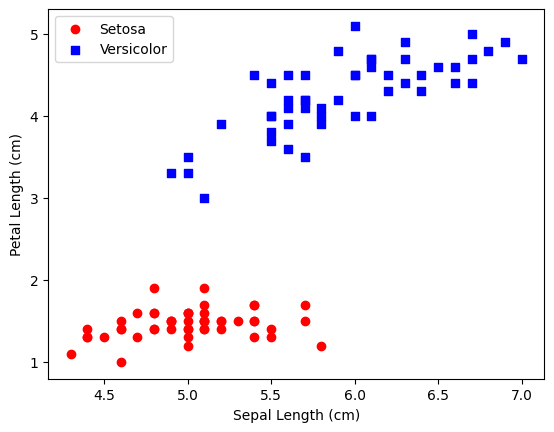

In [11]:
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='s', label='Versicolor')
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Petal Length (cm)")
plt.legend(loc='upper left')
plt.show()

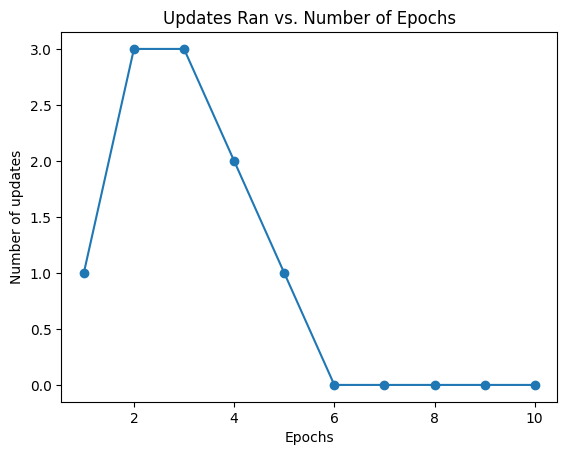

In [14]:
# Initialize the preceptron
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y_bin)
plt.plot(range(1, len(ppn.errors_) + 1),
         ppn.errors_, marker='o')
plt.title("Updates Ran vs. Number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Number of updates")
plt.show()

From the above plot it appears that after 6 epochs the model is perfectly fit to the data. Since the data are 2D we can plot the decision boundaries. 

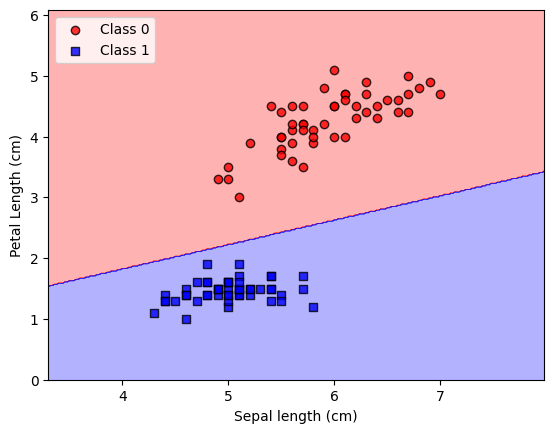

In [17]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generators and color map
    markers = ('o', 's', '^', 'v', '<')
    colors =  ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y = X[y == cl, 1], 
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black'
                    )
                
plot_decision_regions(X, y_bin, classifier=ppn)
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal Length (cm)")
plt.legend(loc="upper left")
plt.show()

As we can see the two classes are well separated by the perceptron approach with the decision boundary being shown as a black diagonal line. 

### Adaptive Linear Neuron (Adaline)

Adaline uses a simple identity function for linear activation, $\sigma(z)=z$.
In the Adaline algorithm the true class label is compared with the linear activation function's continuously valued function to compute errors and update the weights. This is in contrast to the the perceptron model where true class labels are compared to the predicted class labels to determine the error and update the weights. 

#### Minimizing loss functions with Gradient Descent

The **objective function** in machine learning is a function that is optimized during the learning process. In most simple supervised cases we define a cost or loss function we want to minimize across the training process. 

One of the most popular cost functions in supervised learning is the **Mean Squared Error (MSE)**: 

$$L(\bf{w}, b) = \frac{1}{2N}\sum_{i=1}^N (y^{(i)} - \sigma(z^{(i)})^2$$


MSE is a convienent optimization function as it is continuous, differentiable, and convex. 

In [21]:
# Adaline in python with full batch gradient descent

class AdalineGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta= eta
        self.n_iter=n_iter
        self.random_state= random_state
        
    def fit(self, X, y):
        # Init weights and bias
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float(0.0)
        self.losses_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y-output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean() 
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X) >= 0.5, 1, 0))
    
    

Testing the performance of our Adaline implementation for two learning rates. 

C:\Users\dloader\AppData\Local\Temp\ipykernel_19024\3152604308.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.b_ = np.float(0.0)


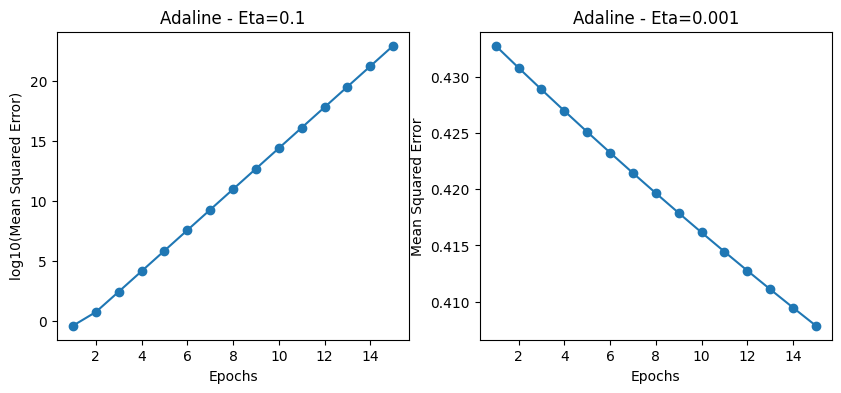

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y_bin)
ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y_bin)
ax[0].plot(range(1, len(ada1.losses_)+1),
           np.log10(ada1.losses_), marker='o')

ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log10(Mean Squared Error)")
ax[0].set_title("Adaline - Eta=0.1")
ax[1].plot(range(1, len(ada2.losses_)+1),
           ada2.losses_, marker="o")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Mean Squared Error")
ax[1].set_title("Adaline - Eta=0.0001")
plt.show()



In the left plot we can see the learning rate chosen is too large and the optimization has 'overshot' the minima so our loss actually increases as we train for more epochs. On the right we have chosen a learning rate that is too small and thus our MSE is decreasing but far too slowly for the simplicity of our data. 

C:\Users\dloader\AppData\Local\Temp\ipykernel_19024\3152604308.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.b_ = np.float(0.0)


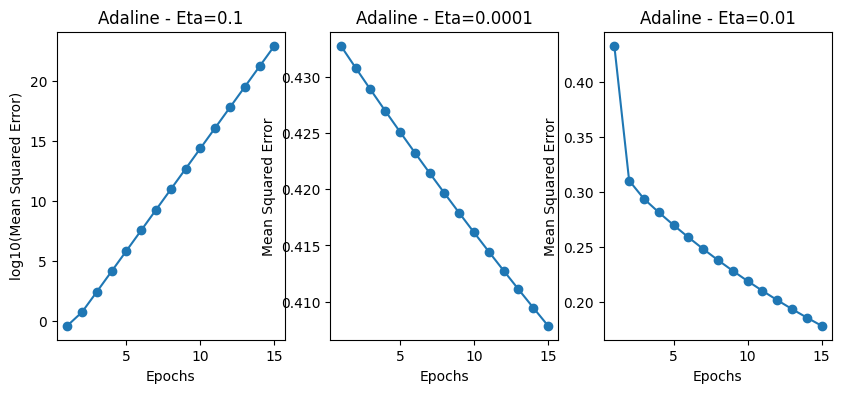

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y_bin)
ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y_bin)
ada3 = AdalineGD(n_iter=15, eta=0.01).fit(X, y_bin)
ax[0].plot(range(1, len(ada1.losses_)+1),
           np.log10(ada1.losses_), marker='o')

ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log10(Mean Squared Error)")
ax[0].set_title("Adaline - Eta=0.1")
# eta=0.0001
ax[1].plot(range(1, len(ada2.losses_)+1),
           ada2.losses_, marker="o")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Mean Squared Error")
ax[1].set_title("Adaline - Eta=0.0001")
# eta=0.01
ax[2].plot(range(1, len(ada3.losses_)+1),
           ada3.losses_, marker="o")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Mean Squared Error")
ax[2].set_title("Adaline - Eta=0.01")
plt.show()

Choosing a much more reasonable learning rate of $\eta=0.01$ we see a sharper decline in MSE over the 15 epochs. This suggests that with more tuning and/or more training epochs we could find a better fit with our Adaline implementation. 

#### Implementing Gradient Descent through Feature Scaling